# Importações

In [1]:
import torch
from torch import nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM,Dense,GRU

import matplotlib.pyplot as plt
import seaborn as sns

#!pip install plotly --upgrade
import plotly.graph_objects as go


# Carregando/Tratando Dados

In [30]:
bicicletas_dados = pd.read_csv("/content/bicicletas.csv")

In [31]:
bicicletas_dados

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


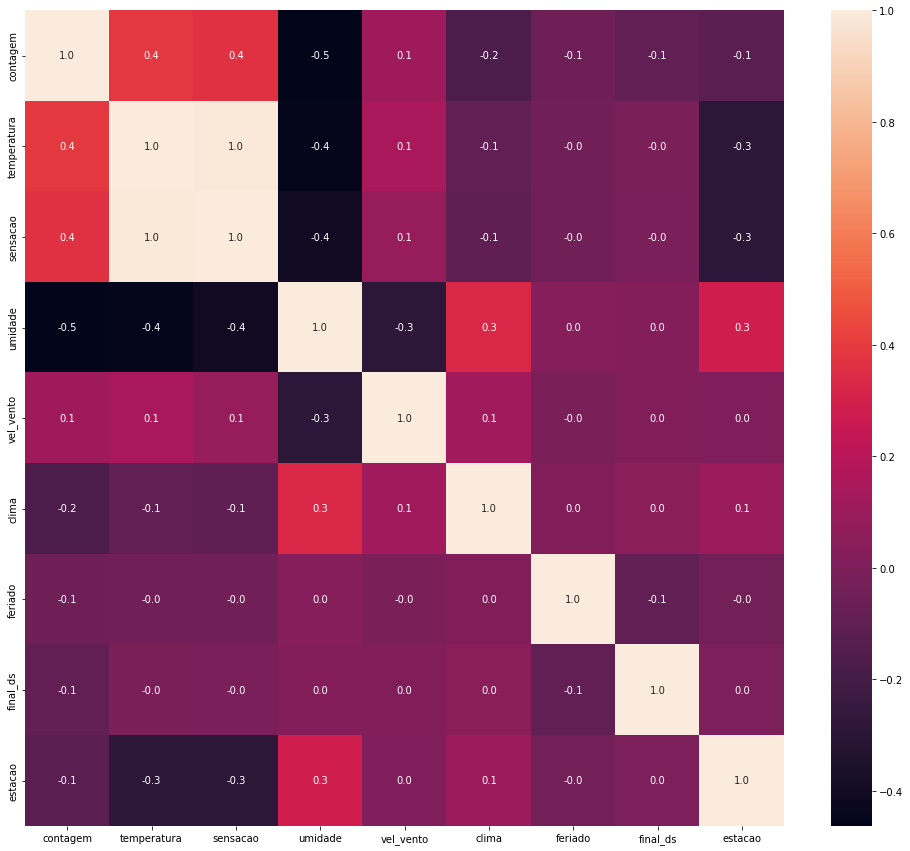

In [32]:
matriz_correlacao = bicicletas_dados.corr()
plt.figure(figsize = (17, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".1f")

In [33]:
bicicletas_dados.isnull().sum()

datas          0
contagem       0
temperatura    0
sensacao       0
umidade        0
vel_vento      0
clima          0
feriado        0
final_ds       0
estacao        0
dtype: int64

In [34]:
bicicletas_dados['datas'] = pd.to_datetime(bicicletas_dados['datas'])

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]), <a list of 9 Text major ticklabel objects>)

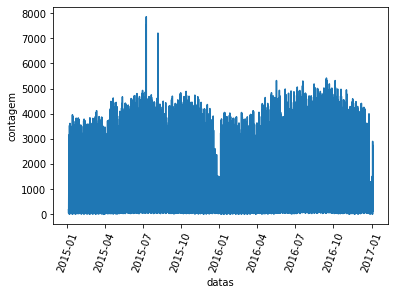

In [35]:
sns.lineplot(x='datas',y='contagem',data = bicicletas_dados);
plt.xticks(rotation=70)

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]), <a list of 9 Text major ticklabel objects>)

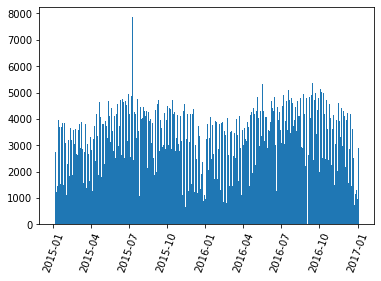

In [36]:
plt.bar(x=bicicletas_dados['datas'].values,height=bicicletas_dados['contagem'].values,)
plt.xticks(rotation=70)

In [37]:
y_= bicicletas_dados['contagem'].values

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y_ = scaler.fit_transform(np.reshape(y_,(len(y_),1)))

In [39]:
def voltar_atras(y,n_atras):
  y=list(np.reshape(y,(len(y),)))
  x=[]
  for n,val in enumerate(y):
    if n>=n_atras:
      x.append(y[n-n_atras:n])
  x=np.array(x)
  y=np.array(y[n_atras:])
  return x,y

In [40]:
x,y = voltar_atras(y_,10)

# Separando Treino e Teste

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20,random_state=0,shuffle=True)

In [42]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13923, 10)
(13923,)
(3481, 10)
(3481,)


# Sklearn

## MLP

In [18]:
mlp = MLPRegressor()
mlp.fit(x_train,y_train)

MLPRegressor()

In [19]:
predicoes = mlp.predict(x_test)


In [20]:
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

In [ ]:
for n,pred in enumerate(predicoes):
  print(int(pred[0]),int(y_test[n][0]))
  if (n+1)%10 == 0:
    break

In [22]:
print(abs(predicoes-y_test).mean())

112.03481188640424


# Keras

## RNN

In [43]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [44]:

recorrente = Sequential()

In [45]:
recorrente.add(LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))#LSTM ou GRU
recorrente.add(Dense(units=1))

In [46]:
recorrente.compile(loss='mean_squared_error',optimizer='RMSProp')

In [47]:
recorrente.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [48]:
resultado = recorrente.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=200)

Epoch 1/200
436/436 [==============================] - 6s 7ms/step - loss: 0.2473 - val_loss: 0.3260
Epoch 2/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0855 - val_loss: 0.0745
Epoch 3/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0580 - val_loss: 0.0648
Epoch 4/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0494 - val_loss: 0.0402
Epoch 5/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0439 - val_loss: 0.0477
Epoch 6/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0405 - val_loss: 0.0520
Epoch 7/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0385 - val_loss: 0.0341
Epoch 8/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0360 - val_loss: 0.0368
Epoch 9/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0345 - val_loss: 0.0300
Epoch 10/200
436/436 [==============================] - 2s 5ms/step - loss: 0.0336 - val_lo

In [49]:
predicoes = recorrente.predict(x_test)

In [50]:
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

In [51]:
for n,pred in enumerate(predicoes):
  print(int(pred[0]),int(y_test[n][0]))
  if (n+1)%10 == 0:
    break

786 773
44 27
410 302
1064 924
841 919
871 756
895 949
1824 1848
1591 1497
223 213


In [52]:
print(abs(predicoes-y_test).mean())

111.33176657133697


# Pytorch

In [9]:
class RNN(nn.Module):
  def __init__(self,tam_entrada,tam_hidden,tam_saida):
    super(RNN,self).__init__()
    self.tam_hidden = tam_hidden

    self.recurrent = nn.RNNCell(tam_entrada,tam_hidden)
    self.saida = nn.Linear(tam_hidden,tam_saida)

  def forward(self,dados):

    h = torch.zeros(1,self.tam_hidden)

    for dado in dados:
      h = self.recurrent(dado.unsqueeze(8),h)
    saida = self.saida(h)




    return saida

modelo = RNN(1,256,1).to(device)

In [11]:
criterio = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(modelo.parameters(),lr=1e-3,weight_decay=1e-5)